In [96]:
import json
import numpy   as np
import pandas  as pd
import re
import sklearn as sk
import torch
from IPython.core.pylabtools import figsize

from matplotlib                import (pyplot
                                       as plt)
from plumbum.colors            import (bold,
                                       underline)
from pprint                    import (pprint,
                                       pp)
from sklearn.decomposition     import KernelPCA
from sklearn.ensemble          import RandomForestRegressor
from sklearn.feature_selection import (mutual_info_regression,
                                       r_regression)
from sklearn.linear_model      import (LinearRegression,
                                       Ridge,
                                       Lasso)
from sklearn.tree              import DecisionTreeRegressor
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import StandardScaler

from torch import nn


In [97]:
df_dir = "../dataset/dataset/LinearTwoBarTruss/20241101_223650/"
with open(df_dir + "info.json") as f:
    info = json.load(f)
df = pd.read_csv(df_dir + "data.csv", nrows=10_000)

print("Model characteristics" | bold)
pprint(info, sort_dicts=False)

Model characteristics
{'date': '01/11/2024 22:36:50',
 'model': 'LinearTwoBarTruss',
 'size': 100000,
 'model_arguments': {'name': "Linear cantilever's cross pattern beam",
                     'parameters': {'length': {'default': {'type': 'UNIFORM',
                                                           'parameters': [2.0,
                                                                          10.0]}},
                                    'height': {'default': {'type': 'UNIFORM',
                                                           'parameters': [2.0,
                                                                          10.0]}},
                                    'supports': {'default': {'type': 'CONSTANT',
                                                             'parameters': [0]},
                                                 '0-x': {'type': 'CONSTANT',
                                                         'parameters': [1]},
                               

# Data preprocessing
In this section, we're applying the following preprocessing to the data:
- Removing useless features
- Isolating loss related data (i.e. the stiffness matrix)
- Separating the features from the target

In [98]:
print("List of dataset features:" | bold)
pprint(df.columns)

List of dataset features:
Index(['height', 'length', 'x_0', 'x_1', 'x_2', 'y_0', 'y_1', 'y_2', 'fix_x_0',
       'fix_x_1', 'fix_x_2', 'fix_y_0', 'fix_y_1', 'fix_y_2', 'P_x_0', 'P_x_1',
       'P_x_2', 'P_y_0', 'P_y_1', 'P_y_2', 'u_x_0', 'u_x_1', 'u_x_2', 'u_y_0',
       'u_y_1', 'u_y_2', 'E_0', 'E_1', 'A_0', 'A_1', 'N_0', 'N_1', 'K_0',
       'K_1', 'K_2', 'K_3', 'K_4', 'K_5', 'K_6', 'K_7', 'K_8', 'K_9', 'K_10',
       'K_11', 'K_12', 'K_13', 'K_14', 'K_15', 'K_16', 'K_17', 'K_18', 'K_19',
       'K_20', 'K_21', 'K_22', 'K_23', 'K_24', 'K_25', 'K_26', 'K_27', 'K_28',
       'K_29', 'K_30', 'K_31', 'K_32', 'K_33', 'K_34', 'K_35'],
      dtype='object')


In [99]:
def drop_columns_regex(df, regex:str, inplace=True):
    exp = re.compile(regex)
    dropped = df.drop([col for col in df.columns if exp.match(col)], axis=1, inplace=inplace)
    return dropped

# Drop useless data
drop_columns_regex(df, 'fix_[x,y]_[0..9]*', inplace=True) # Drop supports
drop_columns_regex(df, 'P_[x,y]_[0,1,2]', inplace=True) # Drop loads on nodes as it is constant
drop_columns_regex(df, 'u_[x,y]_[0,1]', inplace=True) # Drop displacements of nodes 0, 1
K = df[[col for col in df.columns if re.compile('K_[0..9]*').match(col)]] # Get the stiffness matrix
drop_columns_regex(df, 'K_[0..9]*', inplace=True)

# Process the stiffness matrix
K_size = int(len(K.iloc[0])**.5) # K is a square matrix by definition
K = K.apply(lambda K_i: np.reshape(K_i, (K_size, K_size)).astype(float), axis=1)

# Isolate data and target
target_columns = [col for col in df.columns if re.compile('[E,A]_[0..9]*').match(col)]
features_columns = [col for col in df.columns if col not in target_columns]

X = df[features_columns]
y = df[target_columns]

In [100]:
print("Size of the dataset:\n" | bold, len(X), '\n')
print("Features:\n" | bold, list(X.columns), '\n')
print("Targets:\n" | bold, list(y.columns), '\n')

Size of the dataset:
 10000 

Features:
 ['height', 'length', 'x_0', 'x_1', 'x_2', 'y_0', 'y_1', 'y_2', 'u_x_2', 'u_y_2', 'N_0', 'N_1'] 

Targets:
 ['E_0', 'E_1', 'A_0', 'A_1'] 



(array([  33.,   46.,  106.,  151.,  225.,  383.,  566., 1089., 2434.,
        4967.]),
 array([-2432708.00484505, -2240455.83484054, -2048203.66483603,
        -1855951.49483152, -1663699.324827  , -1471447.15482249,
        -1279194.98481798, -1086942.81481346,  -894690.64480895,
         -702438.47480444,  -510186.30479992]),
 <BarContainer object of 10 artists>)

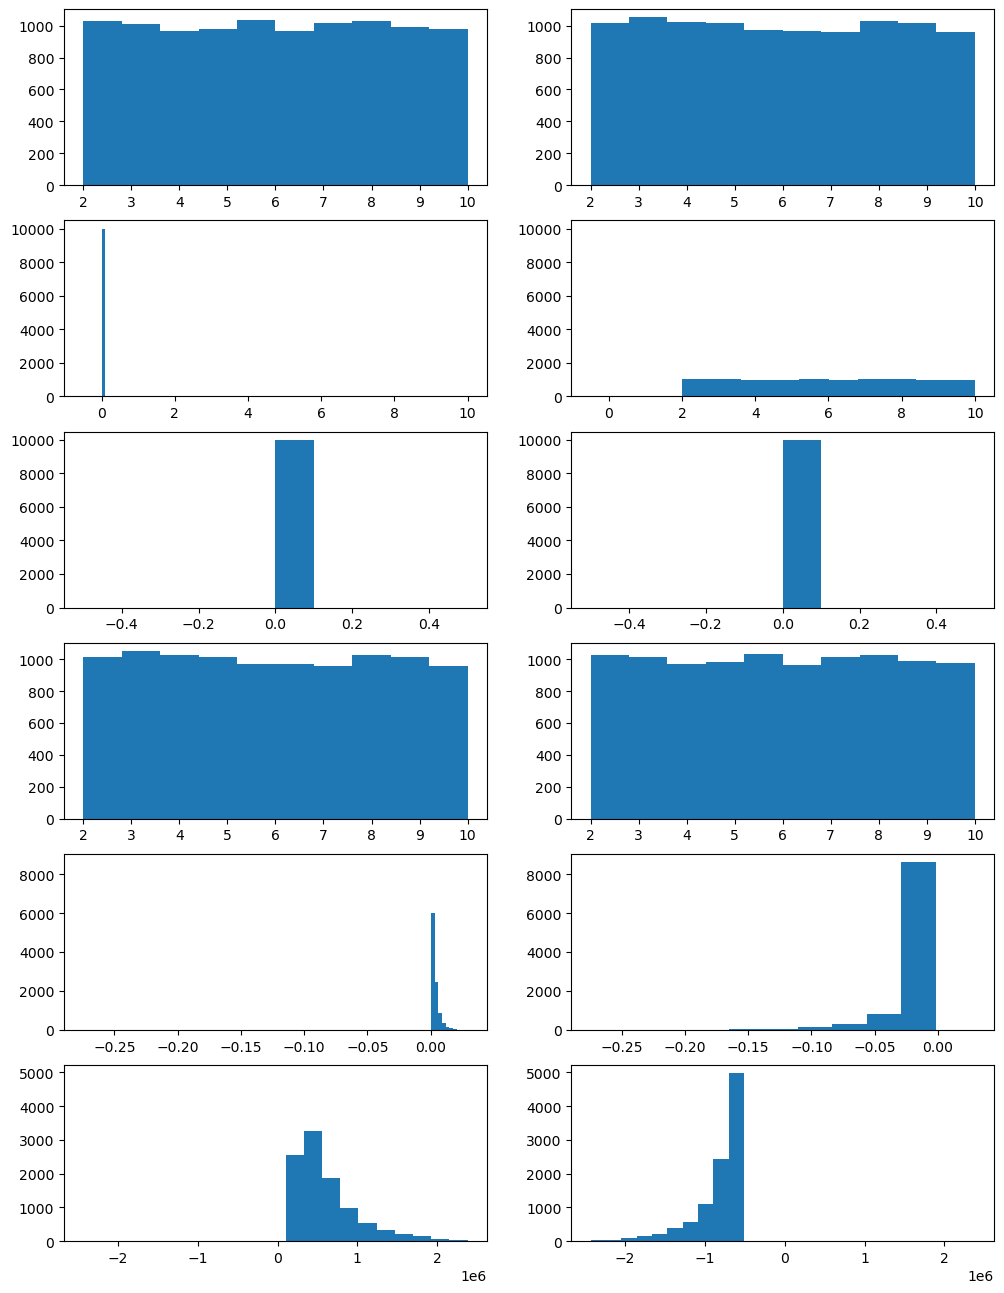

In [106]:
fig, axes = plt.subplots(6, 2, figsize=(12, 16))
for i in range(6):
    axes[i,0].sharex(axes[i,1])
    axes[i,0].sharey(axes[i,1])
    
axes[0,0].hist(X['height'])
axes[0,1].hist(X['length'])
axes[1,0].hist(X['x_0'])
axes[1,1].hist(X['y_0'])
axes[2,0].hist(X['x_1'])
axes[2,1].hist(X['y_1'])
axes[3,0].hist(X['x_2'])
axes[3,1].hist(X['y_2'])
axes[4,0].hist(X['u_x_2'])
axes[4,1].hist(X['u_y_2'])
axes[5,0].hist(X['N_0'])
axes[5,1].hist(X['N_1'])

In [ ]:
L1 = length
L2 = (length**2. + height**2.)**0.5

# Model preprocessor
In this section we are going to develop the preprocessor from the model. We are going to explore the following setup

## Standardization
The standardization is a process in which the data is transformed using:

$$\phi(\mu, \sigma) : \mathcal{N}(\mu, \sigma) \longmapsto \mathcal{N}(0,1)$$
$$\phi(\mu, \sigma) : x \longmapsto \frac{x-\mu}{\sigma}$$

The transformer, like the model is trained on the data, if no prior knowledge of $\mu$ and $\sigma$ is known.

## PCA
Principal component analysis is a process in which  the data is mapped with:
$$\phi : X \longmapsto X^*$$
$$\phi : x \longmapsto x\Lambda$$

where $$\Lambda_i = \frac{v_i}{\lambda_i}$$ with $v_i$ the $i$-th eigenvector of the covariance matrix $\Sigma$ between $X$ and $y$ sorted by the absolute values of eigen value $\lambda_i$.

Can be done with or without whitening that is an operation that normalize the variance in each of the principal component.

## kPCA
Kernel principal component analysis is the same operation as PCA except that we apply PCA in a non-linearly mapped data.
Whitening is highly recommended with kPCA, so we won't consider non-whitened kPCA.


# Model training

In [ ]:
def model_training(model, X, y, folds=10):
    model.fit(X, y)
def model_tuning(model, X, y, folds=5):
    pass
def model_assessement(model, X, y, folds=2):
    pass